In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import glob

import cv2

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2022-10-03 08:14:52.195453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 08:14:52.225215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 08:14:52.225363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
ds_train = image_dataset_from_directory(
'tiny_imagenet/train',
image_size=(64,64),
batch_size=32)

Found 100000 files belonging to 200 classes.


2022-10-03 08:14:58.080356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 08:14:58.080522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 08:14:58.080626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 08:14:58.581303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 08:14:58.581441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [4]:
ds_val = image_dataset_from_directory(
'tiny_imagenet/val',
image_size=(64,64),
batch_size=32)

Found 10000 files belonging to 200 classes.


In [5]:
data_augmentation = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)

inputs = keras.Input(shape=(64,64,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32,64,128,256,512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(200, activation="softmax")(x)
model = keras.Model(inputs, outputs)

opt = tf.optimizers.Adam(learning_rate=0.0001)


model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="tiny_imagenet_feature_extraction_with_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

In [6]:
history = model.fit(
ds_train,
epochs=50,
validation_data=ds_val,
callbacks=callbacks)

Epoch 1/50


2022-10-02 19:18:19.836791: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303
2022-10-02 19:18:21.054005: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3125/3125 [==============================] - 106s 33ms/step - loss: 5.0774 - accuracy: 0.0206 - val_loss: 4.8296 - val_accuracy: 0.0410
Epoch 2/50
3125/3125 [==============================] - 101s 32ms/step - loss: 4.6948 - accuracy: 0.0491 - val_loss: 4.6284 - val_accuracy: 0.0588
Epoch 3/50
3125/3125 [==============================] - 102s 33ms/step - loss: 4.4747 - accuracy: 0.0725 - val_loss: 4.4678 - val_accuracy: 0.0818
Epoch 4/50
3125/3125 [==============================] - 95s 30ms/step - loss: 4.3020 - accuracy: 0.0949 - val_loss: 4.3369 - val_accuracy: 0.0893
Epoch 5/50
3125/3125 [==============================] - 95s 30ms/step - loss: 4.1619 - accuracy: 0.1117 - val_loss: 4.2096 - val_accuracy: 0.1050
Epoch 6/50
3125/3125 [==============================] - 95s 31ms/step - loss: 4.0516 - accuracy: 0.1284 - val_loss: 4.0730 - val_accuracy: 0.1222
Epoch 7/50
3125/3125 [==============================] - 96s 31ms/step - loss: 3.9530 - accuracy: 0.1417 - val_loss: 3.8738 - val_acc

In [5]:
ds_train = ds_train.unbatch()

In [6]:
x_train = np.uint8(np.asarray(list(ds_train.map(lambda x, y: x))))

In [7]:
y_train = np.asarray(list(ds_train.map(lambda x, y: y)))

In [8]:
from hdr_blend import*

end = len(x_train)

x_dataAug = []
y_dataAug = []
for image in range(0,end):
    x_dataAug.append(hdr(x_train[image]))
    y_dataAug.append(y_train[image])


x_dataAug = np.asarray(x_dataAug, dtype=int)
y_dataAug = np.asarray(y_dataAug)

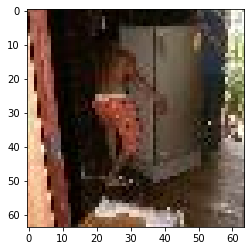

In [11]:
plt.imshow(x_train[0])

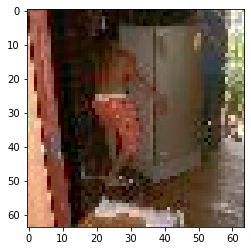

In [12]:
plt.imshow(x_dataAug[0])

In [19]:
print(y_dataAug[1])

138


In [ ]:
dsAug_train = tf.data.Dataset.from_tensor_slices((x_train,y_train))

: 

: 

In [12]:
dsAug_train.element_spec

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [20]:
len(dsAug_train)

3125

In [10]:
data_augmentation = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)

inputs = keras.Input(shape=(64,64,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32,64,128,256,512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(200, activation="softmax")(x)
model = keras.Model(inputs, outputs)

opt = tf.optimizers.Adam(learning_rate=0.0001)


model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="tiny_imagenet_feature_extraction_with_data_augmentation_HDR  .keras",
save_best_only=True,
monitor="val_loss")
]

In [11]:
history_Aug = model.fit(
dsAug_train,
epochs=100,
validation_data=ds_val,
callbacks=callbacks)

Epoch 1/100


2022-10-03 09:18:24.975747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303
2022-10-03 09:18:26.192740: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3125/3125 [==============================] - 106s 33ms/step - loss: 5.3013 - accuracy: 0.0048 - val_loss: 5.2984 - val_accuracy: 0.0047
Epoch 2/100
1071/3125 [=========>....................] - ETA: 1:03 - loss: 5.2997 - accuracy: 0.0052

InternalError: Could not synchronize CUDA stream: CUDA_ERROR_LAUNCH_FAILED: unspecified launch failure